In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

In [3]:
#importing total X_train(features)
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X.csv')

In [4]:
#importing total Y_train(target)
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y.csv')

In [5]:
#splitting train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
#model building and fitting
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier()

In [7]:
#train accuracy
xg_clf.score(X_train, y_train)

0.8922611111111111

In [8]:
#test accuracy
yPred = xg_clf.predict(X_test)
xg_clf.score(X_test, y_test)

0.8918611111111111

In [9]:
#various performance scores
acc = accuracy_score(y_test, yPred)
print("The accuracy is {}".format(acc))
  
prec = precision_score(y_test, yPred)
print("The precision is {}".format(prec))
  
rec = recall_score(y_test, yPred)
print("The recall is {}".format(rec))
  
f1 = f1_score(y_test, yPred)
print("The F1-Score is {}".format(f1))
  
MCC = matthews_corrcoef(y_test, yPred)
print("The Matthews correlation coefficient is{}".format(MCC))

The accuracy is 0.8918611111111111
The precision is 0.588078588078588
The recall is 0.08832649794938481
The F1-Score is 0.15358525025003258
The Matthews correlation coefficient is0.19772808363229727


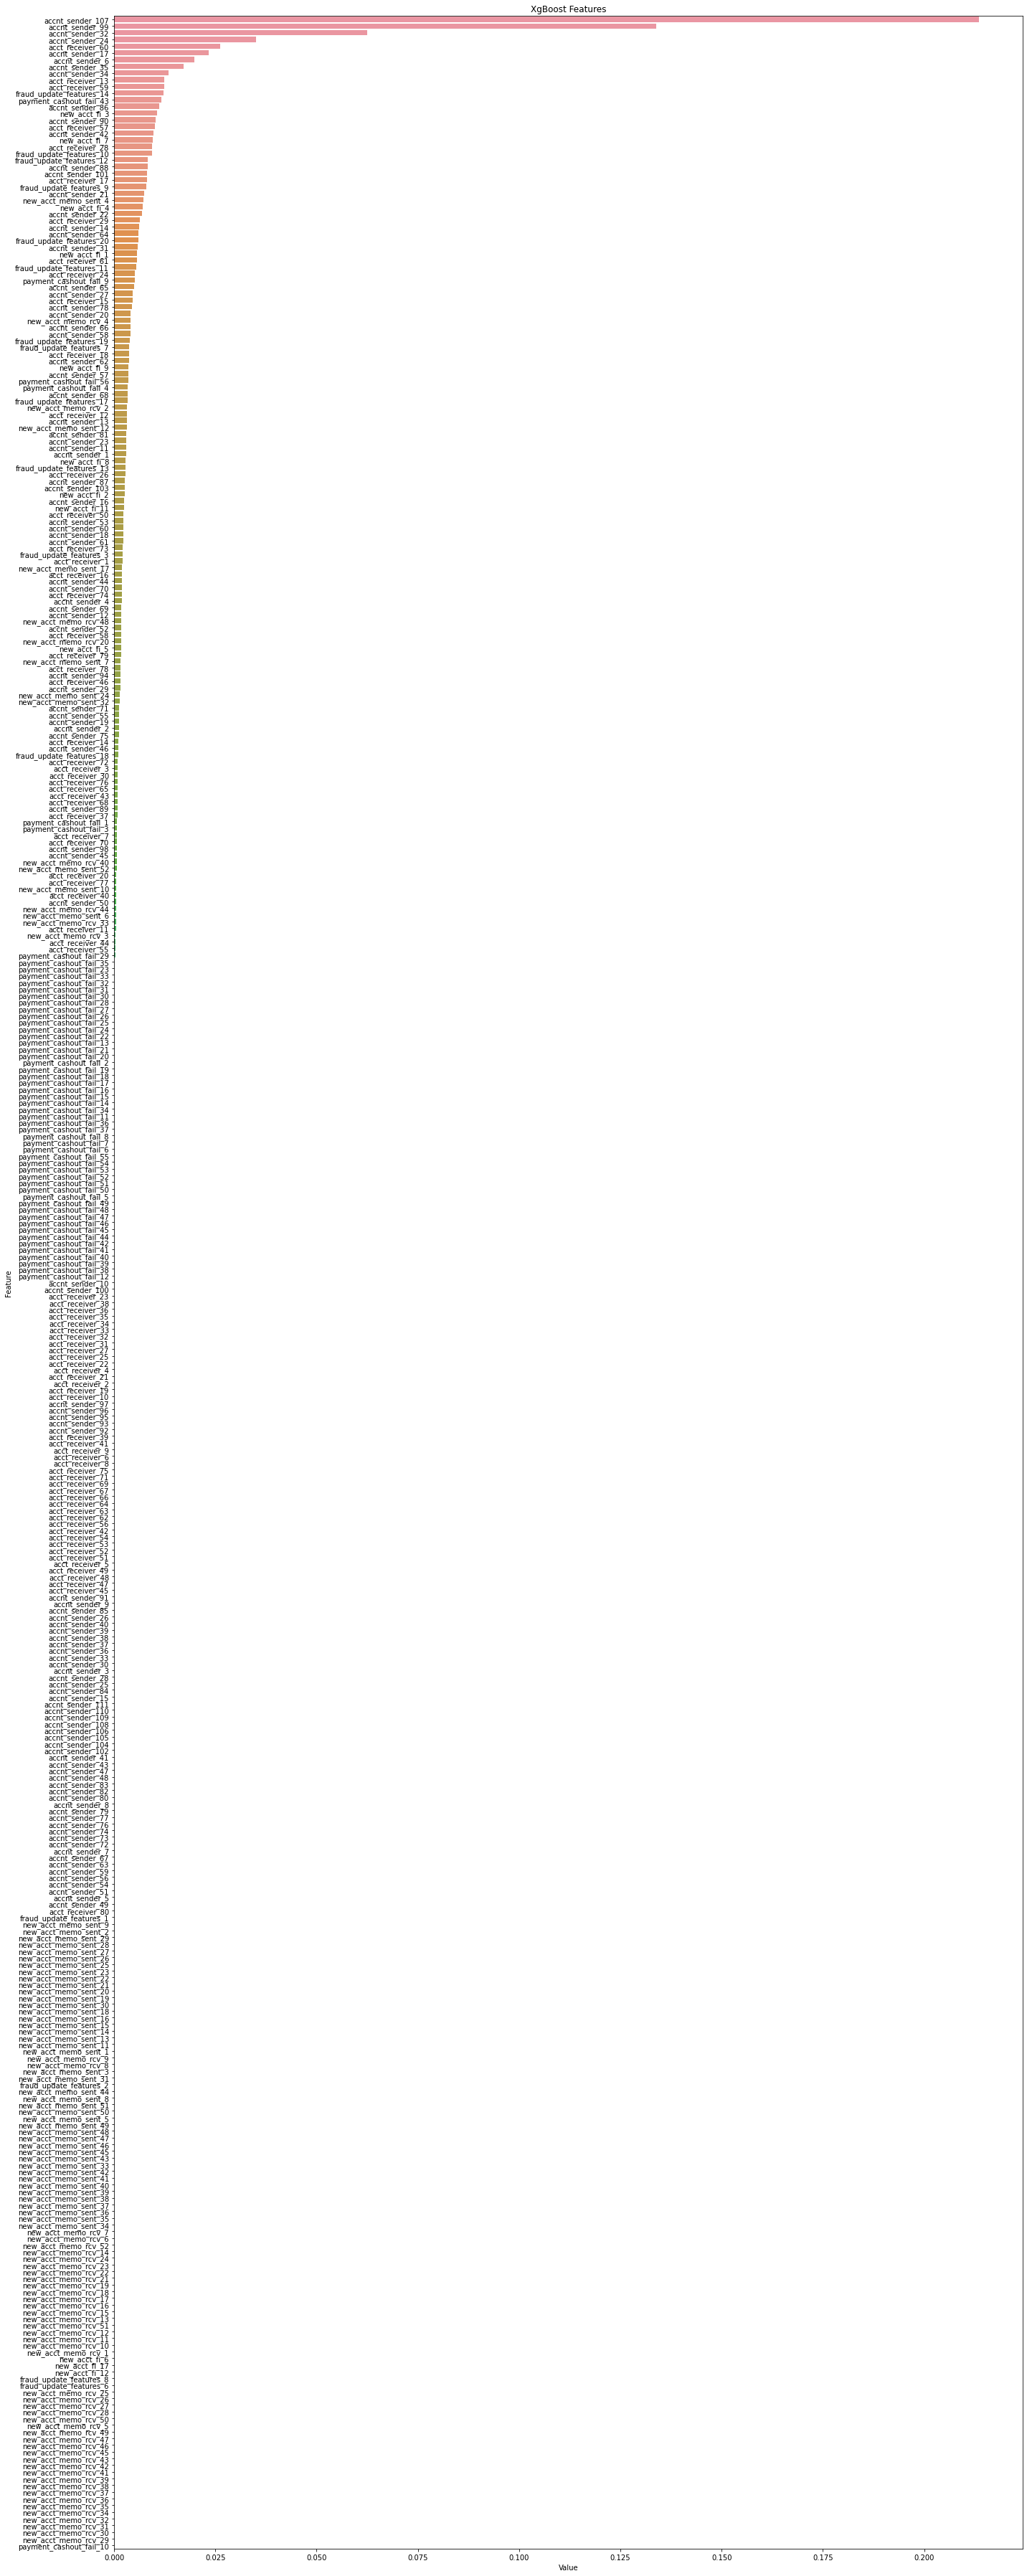

In [10]:
feature_imp = pd.DataFrame(sorted(zip(xg_clf.feature_importances_,X.columns)), columns=['Value','Feature'])
feature_imp.sort_values(by="Value", ascending=False,inplace=True)
plt.figure(figsize=(20, 50))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('XgBoost Features')
plt.tight_layout()
plt.show()

In [11]:
feature_imp_top100= feature_imp.iloc[:100]

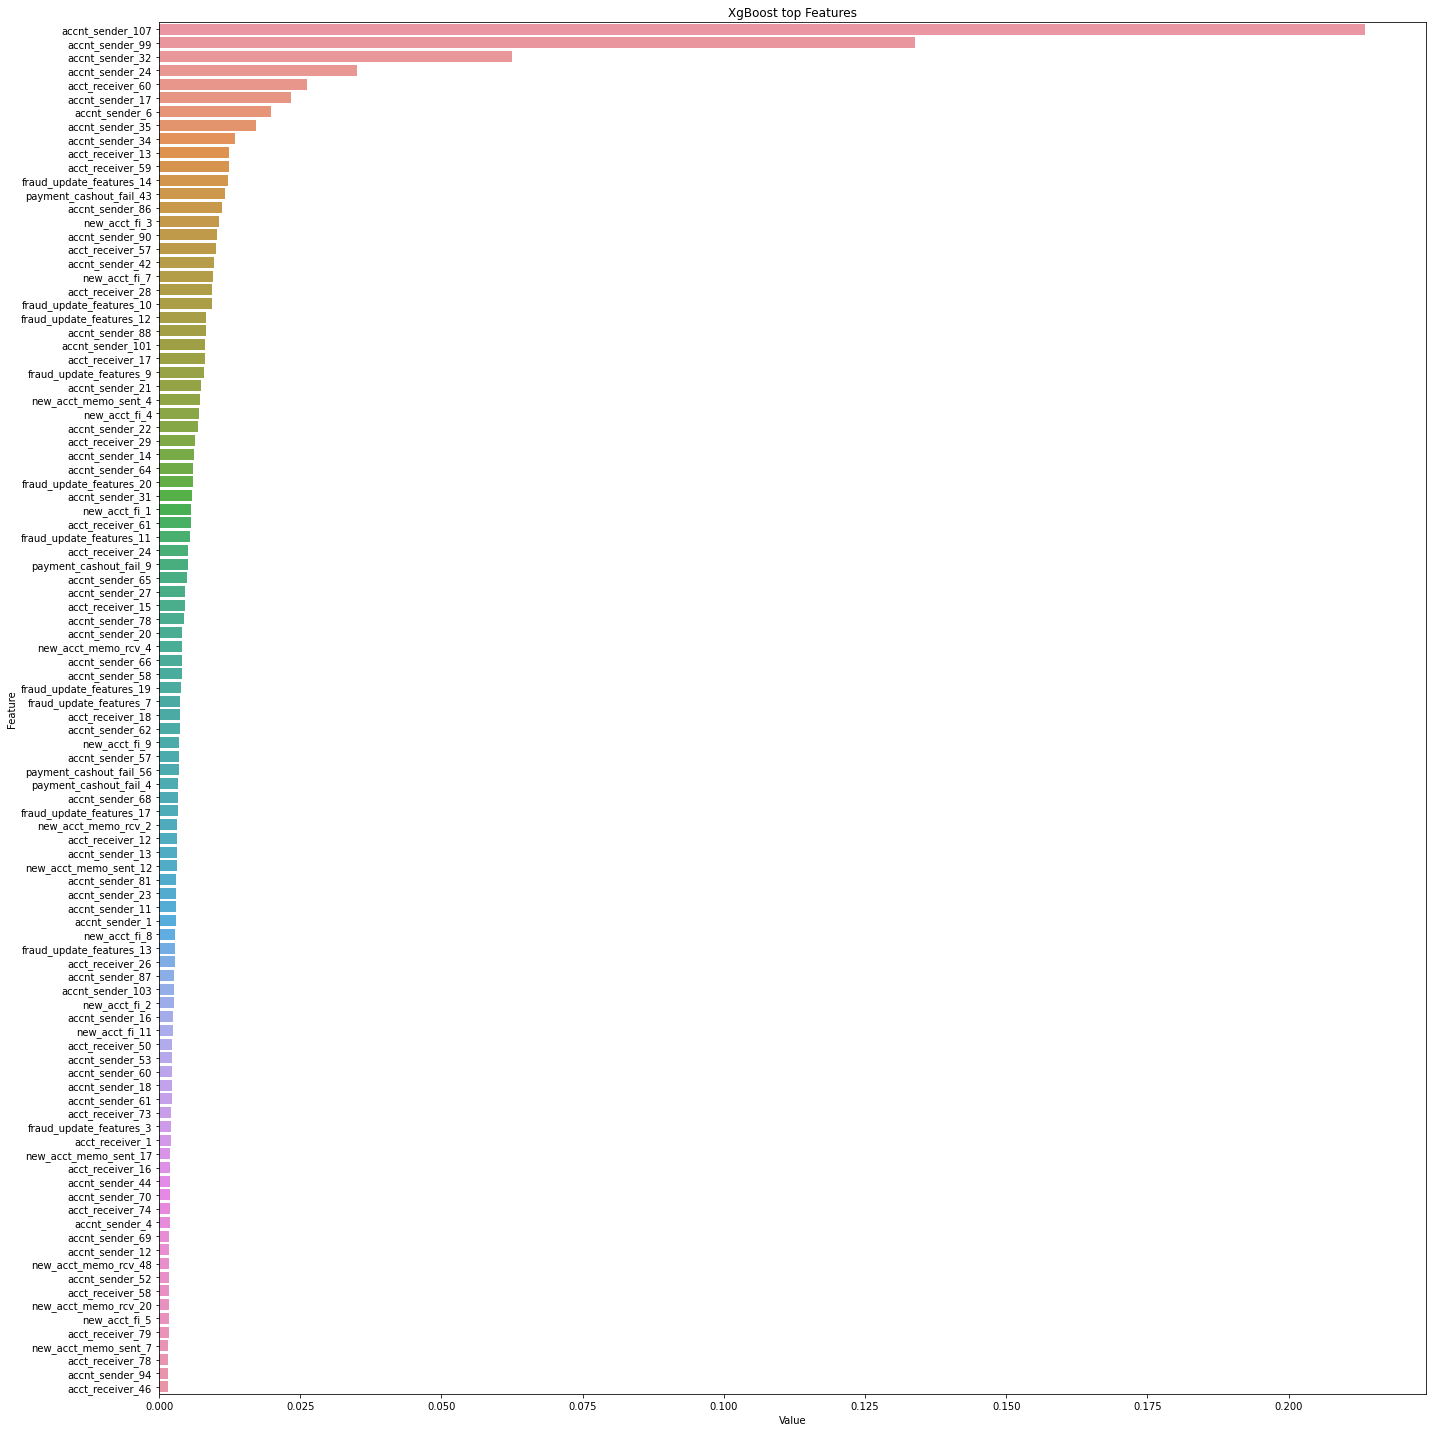

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp_top100)
plt.title('XgBoost top Features')
plt.tight_layout()
plt.show()
plt.savefig('xgb_importances.png')
from google.colab import files
files.download('xgb_importances.png')

In [13]:
features= list(feature_imp_top100.Feature)

In [14]:
#ks score function
def ks_(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100
    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    return 

In [15]:
#creating data frame to check ks score for validation data
ks=pd.DataFrame(xg_clf.predict_proba(X_test))
del ks[0]

In [16]:
y_test.reset_index(inplace=True)
ks['target']=y_test['target']

#ks table
ks_(ks,'target',1)

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.211800  0.883154  6764.0    11236.0     33.83%         7.02%   
2       0.139150  0.211793  3276.0    14724.0     16.38%         9.20%   
3       0.107061  0.139146  2326.0    15674.0     11.63%         9.80%   
4       0.088391  0.107060  1827.0    16173.0      9.14%        10.11%   
5       0.076285  0.088389  1483.0    16517.0      7.42%        10.32%   
6       0.067441  0.076285  1206.0    16794.0      6.03%        10.50%   
7       0.060225  0.067440  1062.0    16938.0      5.31%        10.59%   
8       0.053689  0.060225   817.0    16986.0      4.09%        10.62%   
9       0.046152  0.053687   726.0    17471.0      3.63%        10.92%   
10      0.021043  0.046151   507.0    17493.0      2.54%        10.93%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             33.83

In [17]:
#creating data frame of cust ids with probabilities
X_t= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_t.csv')
test_cust= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_cust.csv')
result_model = pd.DataFrame(xg_clf.predict_proba(X_t))
result=pd.concat([test_cust['cust_id'],result_model[1] ], axis=1)
result.rename(columns={1:'target'},inplace=True)

In [18]:
result

,cust_id,target
0,10146566,0.101694
1,10203613,0.069806
2,10322129,0.029775
3,10373212,0.060310
4,10487539,0.050825
...,...,...
179995,45739460,0.044311
179996,56006782,0.037604
179997,61138340,0.048920
179998,65715392,0.034497


In [19]:
#uploading results(probabilities)
#result.to_csv('/content/drive/MyDrive/Colab Notebooks/results.csv',index=False)